In [1]:
import svgwrite
import numpy as np
import time
import random
import pickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange
import pandas as pd

In [2]:
# libraries required for visualisation:
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

# Data

## Fonctions to work with svg data

In [3]:
# helper function for draw_strokes
def get_bounds(data, factor):
  min_x = 0
  max_x = 0
  min_y = 0
  max_y = 0
    
  abs_x = 0
  abs_y = 0
  for i in xrange(len(data)):
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    abs_x += x
    abs_y += y
    min_x = min(min_x, abs_x)
    min_y = min(min_y, abs_y)
    max_x = max(max_x, abs_x)
    max_y = max(max_y, abs_y)
    
  return (min_x, max_x, min_y, max_y)

# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=2, svg_filename = 'sample.svg'):
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(0,20):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "red"
  stroke_width = 2
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  for i in xrange(20,len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=15.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)
#test_set = np.load(data_dir, encoding='latin1', allow_pickle=True)
# get a sample drawing from the test set, and render it to .svg



70000
2500
2500


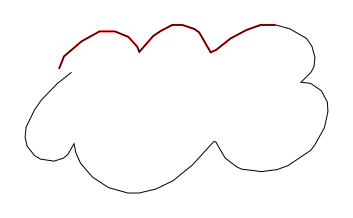

In [4]:
#Focus on cloud for the begining
data_dir = 'cloud.npz'

load_data = np.load(data_dir, encoding='latin1', allow_pickle=True) #specific to python3
train_set = load_data['train']
valid_set = load_data['valid']
test_set = load_data['test']

print (len(train_set))
print (len(valid_set))
print (len(test_set))

draw_strokes(random.choice(test_set))

In [8]:
from typing import List, Tuple
import numpy as np
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler

def create_window(input_data: np.array, window_size: int) -> np.array:
    data_len = len(input_data)
    result = np.zeros((data_len-window_size+1, window_size, *input_data.shape[1:]))
    for i in range(data_len):
        if i+window_size <= data_len:
            result[i] = input_data[i:i+window_size]
    return result


def create_window_on_multiple_samples(input_data: np.array, window_size: int, normalized = False) -> np.array:
    """
    Similar to create_window, but now can take multiple samples, will output in one
    giant windowed np.array.
    """
    windowed_data = []
    scaler = MinMaxScaler()
    for i, sample in enumerate(input_data):
        win = create_window(sample[:,:2], window_size)
        
        # Normalize the data
        if normalized:
            win = normalise_windows(win)
            
        windowed_data.append(win)
        
        if i % 100 == 0:
            print(f"Now at {i}")
            clear_output(wait=True)
    result = np.concatenate(windowed_data)
#     print(f"result = {result} \t winddata = {windowed_data}")
    print(f"Done processing {i} samples, total of {result.shape[0]} windows and {result.shape[0] * result.shape[1]} datapoints")
    return np.concatenate(result)


def split_train_test(input_data: List) -> Tuple[np.array, np.array]:
    return input_data[:,:-1], input_data[:,-1]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    scaler = MinMaxScaler()
    normalised_data = []
    for window in window_data:
        scaled = scaler.fit_transform(window)
        normalised_data.append(scaled)
    return np.concatenate(normalised_data)


In [9]:
x = create_window_on_multiple_samples(train_set[:500], 7, True) 

Done processing 499 samples, total of 186704 windows and 373408 datapoints


In [10]:
# x
X, Y = split_train_test(x)
# X
# X = np.asarray(X).astype('float32')
# Y = np.asarray(Y).astype('float32')

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
print(X[0])

# LSTM Model Structure

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from matplotlib import pyplot

# Initialize LSTM
model = Sequential()
# print (train_set[3].shape)
model.add(LSTM(units=50, return_sequences=True,
     input_shape=(X.shape[0], 2)))

# Adding a second LSTM layer and Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# # Adding a fourth LSTM layer and Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mse')
# history = model.fit(X, Y, epochs=10, validation_data=(test_set, valid_set), shuffle=False)
print(model.summary())
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(X, Y, epochs = 200)
# history = model.fit(X, Y, epochs=10, validation_data=(test_set, valid_set), shuffle=False)

# plot train and validation loss
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
# Fit LSTM model
# history = model.fit(X, Y, epochs = 100, batch_size = 50, verbose = 1)
# plt.figure()
# plt.ylabel('loss'); plt.xlabel('epoch')
plt.semilogy(history.history['loss'])

In [ ]:
# X= np.empty([0,S_reg*3])
# line= np.array([])
# Y=np.array([])

In [ ]:
# #warning: x goes into floating...
# for data in test_set:
#     i=20
#     while i <= (len(data)-1):
#         line= np.array([])
#         for j in range (S_reg):
#             line = np.concatenate((line, data[i-S_reg+j]), 0)
#         #print(X,line)
#         X = np.vstack((X, line))
#         Y = np.concatenate((Y, data[i]), 0) #to change
#         i+=1

In [ ]:
# Y=Y.reshape((int(len(Y)/3), 3)) #to change
# X=X.T

In [ ]:
# inv=np.linalg.inv(np.dot(X,X.T)+0.01*np.identity(S_reg*3))

In [ ]:
# W=np.dot(np.dot(inv,X),Y)

## Testing the model

In [ ]:
# for test in range (0,100):
#     ini=np.array([])
#     for i in range(20):
#         ini=np.concatenate((ini, train_set[test][i]), 0)
#     draw=train_set[test][0:20]
#     for i in range (300):
#         draw=np.vstack((draw, np.dot(W.T,ini)))
#         ini=np.concatenate((ini, draw[-1]), 0)
#         ini = np.delete(ini, [0,1,2])
#     draw[:, 2]=0 # I do not take into account the different strokes
#     draw_strokes(draw)

# Echo State network

## Creating the model

In [ ]:
# for count,sample in enumerate(train_set[0:2500]):
#     if count==0:
#         X_train=sample
#     else:
#         X_train = np.vstack((X_train,sample))
#     train_set[count]=np.tanh(np.delete(sample, 2, axis=1)/100) #trick for not caring about different strokes 

In [ ]:
# # -*- coding: utf-8 -*-
# """
# A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
# in "plain" scientific Python.
# from https://mantas.info/code/simple_esn/
# (c) 2012-2020 Mantas LukoÅ¡eviÄius
# Distributed under MIT license https://opensource.org/licenses/MIT
# """
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import linalg 
# # numpy.linalg is also an option for even fewer dependencies

# # load the data
# data = train_set[0:2000]
# trainLen = len(X_train) 
# testLen = len(X_train) 
# initLen = 0 #Warning higly reduced


# # generate the ESN reservoir
# inSize = outSize = 2
# resSize = 1000
# L_a = [0.3,1,5] # leaking rate
# np.random.seed(42)
# L_Win = [(np.random.rand(resSize,1+inSize) - 0.5) *i for i in [0.1,1,2]]
# label_Win = [0.1,1,2]

# W = np.random.rand(resSize,resSize) - 0.5 
# # normalizing and setting spectral radius (correct, slow):
# print('Computing spectral radius...')
# rhoW = max(abs(linalg.eig(W)[0]))
# print('done.')
# L_W = [W*i / rhoW for i in [0.75,1,1.25]]
# label_W = [0.75,1,1.5]

# # allocated memory for the design (collected states) matrix
# X = np.zeros((1+inSize+resSize,trainLen-(initLen+1)*len(data)))
# Yt = np.zeros((outSize,trainLen-(initLen+1)*len(data)))

# # set the corresponding target matrix directly
# #Yt = data[None,initLen+1:trainLen+1] 

# print("run reservoir")
# L_XXT=[]
# L_XYT=[]
# # run the reservoir with the data and collect X
# i=0
# for W in L_W:
#      for Win in L_Win:
#         for a in L_a:
#             i+=1
#             print(i)
#             # allocated memory for the design (collected states) matrix
#             X = np.zeros((1+inSize+resSize,trainLen-(initLen+1)*len(data)))
#             Yt = np.zeros((outSize,trainLen-(initLen+1)*len(data)))
#             for sample in data:
#                 x = np.zeros((resSize,1))
#                 count_global=0
#                 for count,u in enumerate(sample):
#                     u=np.array([u]).T
#                     #print(np.vstack((1,u)))
#                     x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#                     if count >= initLen:
#                         count_global += 1
#                         X[:,count_global] = np.vstack((1,u,x))[:,0]
#                         if count >= initLen+1:
#                             Yt[:,count_global-1] = np.vstack((u))[:,0]
#                     if count == len(sample)-2:
#                         Yt[:,count_global-1] = np.vstack((u))[:,0]
#                         break
#             L_XXT.append(np.dot(X,X.T))
#             L_XYT.append(np.dot(X,Yt.T))
                
# print("train reservoir")
# # train the output by ridge regression
# Wout_list=[]
# count=0
# for w,W in zip(label_W,L_W):
#     for win,Win in zip(label_Win,L_Win):
#         for a in L_a:
#             XXT=L_XXT[count]
#             XYT=L_XYT[count]
#             count=+1
#             for i in range(8):
#                 reg = 1^-i  # regularization coefficient
#                 # direct equations from texts:
#                 #X_T = X.T
#                 #Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
#                 #    reg*np.eye(1+inSize+resSize) ) )
#                 # using scipy.linalg.solve:
#                 Wout = linalg.solve( XXT + reg*np.eye(1+inSize+resSize), 
#                     XYT ).T
#                 Wout_list.append([Wout,W,str(w),Win,str(win),a,i])

In [ ]:
"""
with open("Nz1000_data2000_norm.txt", "wb") as fp:   #Pickling
    pickle.dump(Wout_list, fp)

with open("test.txt", "rb") as fp:   # Unpickling
    Wout_list = pickle.load(fp)"""

In [ ]:
# from numpy import linalg as LA
# L_mse=[]

# for count,Wout in enumerate(Wout_list):
#     Wout,W,w,Win,win,a,i=Wout
#     for number in range (500):
#         Y = np.zeros((outSize, len(data[number])))
#         X = np.zeros((resSize, len(data[number])))
#         u = np.array([data[number][0]]).T
#         x = np.zeros((resSize,1))
#         mse_ini=0
#         mse_fill=0
#         for t in range(len(data[number])):
#             if t <= 15:
#                 u = np.array([data[number][t]]).T
#                 x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#                 y = np.dot(Wout, np.vstack((1,u,x)))
#                 #y=np.array([y]).T
#                 Y[:,t] = y[:,0]
#                 mse_ini += LA.norm(y[:,0]-data[number][t+1])
#             else:
#                 x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#                 y = np.dot( Wout, np.vstack((1,u,x)) )
#                 u = y
#                 #print(y)
#                 #y=np.array([y]).T
#                 Y[:,t] = y[:,0]
#                 # generative mode:
#                 if t < len(data[number])-2:
#                     mse_fill += LA.norm(y[:,0]-data[number][t+1])
#             X[:,t]=np.array([x]).T[:,0]

            
#         mse_ini = mse_ini/(15)
#         mse_fill = mse_fill/len(data[number]-15)

#         row = {'mse_ini' : mse_ini, 'mse_fill' : mse_fill, 'w' : float(w), 'win' : float(win),'a' : float(a),'i' : float(i),'number' : number}
#     L_mse.append(row)       
# df = pd.DataFrame(L_mse)
# df.to_pickle("mse(Nz1000_data2000_norm)")

In [ ]:
# #To plot
# for count,Wout in enumerate(Wout_list):
#     Wout,W,w,Win,win,a,i=Wout
#     if (w==str(1.50)) & (win==str(2)) & (a==1) & (i==3.0):
#         for number in range (0,5):
#             Y = np.zeros((outSize, len(data[number])))
#             X = np.zeros((resSize, len(data[number])))
#             u = np.array([data[number][0]]).T
#             x = np.zeros((resSize,1))
#             mse_ini=0
#             mse_fill=0
#             for t in range(len(data[number])):
#                 if t <= 20:
#                     u = np.array([data[number][t]]).T
#                     x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#                     y = np.dot(Wout, np.vstack((1,u,x)))
#                     #y=np.array([y]).T
#                     Y[:,t] = y[:,0]
#                     mse_ini += LA.norm(y[:,0]-data[number][t+1])
#                 else:
#                     x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#                     y = np.dot( Wout, np.vstack((1,u,x)) )
#                     u = y

#                     Y[:,t] = y[:,0]
#                     # generative mode:
#                     if t < len(data[number])-2:
#                         mse_fill += LA.norm(y[:,0]-data[number][t+1])
#                 X[:,t]=np.array([x]).T[:,0]
                
#             N = 2
#             b = np.zeros((len(data[number]),N+1))
#             b[:,:-1] = Y.T
#             #print(Y.T)
#             #print(b)
#             draw_strokes(b,factor=2,svg_filename = str(number)+'sample.svg')

In [ ]:
#         N = 2
#         a = np.random.rand(N,N)
#         b = np.zeros((N,N+1))
#         b[:,:-1] = a
#         b

In [ ]:
# draw_strokes(b)

In [ ]:
# # -*- coding: utf-8 -*-
# """
# A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
# in "plain" scientific Python.
# from https://mantas.info/code/simple_esn/
# (c) 2012-2020 Mantas LukoÅ¡eviÄius
# Distributed under MIT license https://opensource.org/licenses/MIT
# """
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import linalg 
# # numpy.linalg is also an option for even fewer dependencies

# # load the data
# trainLen = 2000
# testLen = 2000
# initLen = 100
# data = np.loadtxt('MackeyGlass_t17.txt')

# # plot some of it
# plt.figure(10).clear()
# plt.plot(data[:1000])
# plt.title('A sample of data')

# # generate the ESN reservoir
# inSize = outSize = 1
# resSize = 1000
# a = 0.3 # leaking rate
# np.random.seed(42)
# Win = (np.random.rand(resSize,1+inSize) - 0.5) * 1
# W = np.random.rand(resSize,resSize) - 0.5 
# # normalizing and setting spectral radius (correct, slow):
# print('Computing spectral radius...')
# rhoW = max(abs(linalg.eig(W)[0]))
# print('done.')
# W *= 1.25 / rhoW

# # allocated memory for the design (collected states) matrix
# X = np.zeros((1+inSize+resSize,trainLen-initLen))
# # set the corresponding target matrix directly
# Yt = data[None,initLen+1:trainLen+1] 

# # run the reservoir with the data and collect X
# x = np.zeros((resSize,1))
# for t in range(trainLen):
#     u = data[t]
#     x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#     if t >= initLen:
#         X[:,t-initLen] = np.vstack((1,u,x))[:,0]
    
# # train the output by ridge regression
# reg = 1e-8  # regularization coefficient
# # direct equations from texts:
# #X_T = X.T
# #Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
# #    reg*np.eye(1+inSize+resSize) ) )
# # using scipy.linalg.solve:
# Wout = linalg.solve( np.dot(X,X.T) + reg*np.eye(1+inSize+resSize), 
#     np.dot(X,Yt.T) ).T

# # run the trained ESN in a generative mode. no need to initialize here, 
# # because x is initialized with training data and we continue from there.
# Y = np.zeros((outSize,testLen))
# u = data[trainLen]
# for t in range(testLen):
#     x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#     y = np.dot( Wout, np.vstack((1,u,x)) )
#     Y[:,t] = y
#     # generative mode:
#     u = y
#     ## this would be a predictive mode:
#     #u = data[trainLen+t+1] 

# # compute MSE for the first errorLen time steps
# errorLen = 500
# mse = sum( np.square( data[trainLen+1:trainLen+errorLen+1] - 
#     Y[0,0:errorLen] ) ) / errorLen
# print('MSE = ' + str( mse ))
    
# # plot some signals
# plt.figure(1).clear()
# plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
# plt.plot( Y.T, 'b' )
# plt.title('Target and generated signals $y(n)$ starting at $n=0$')
# plt.legend(['Target signal', 'Free-running predicted signal'])

# plt.figure(2).clear()
# plt.plot( X[0:20,0:200].T )
# plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

# plt.figure(3).clear()
# plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
# plt.title(r'Output weights $\mathbf{W}^{out}$')

# plt.show()


## Data_analysis

In [ ]:
# %matplotlib inline
# from matplotlib.pyplot import imshow
# from matplotlib import pyplot as plt
# import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D

In [ ]:
df

In [ ]:
# df['w']

In [ ]:
# df_i=df
# df_i= df.groupby(['w','win','a',"i"])['mse_fill'].mean().reset_index()
# df_i[df_i.mse_fill<0.2]

In [ ]:
# fig = plt.figure(dpi=300)
# ax = fig.gca(projection='3d')
# for i in range (8):

#     df_i=df[df.i == i ]
#     df_i= df_i.groupby(['w','win','a'])['mse_fill'].mean().reset_index()
#     xs = list(df_i['w'])
#     ys = list(df_i['win']+0.05*i)
#     zs = list(df_i['a'])
#     ss = list(df_i['mse_fill'])
#     #print(xs)
    
#     ax.set_xlabel('w')
#     ax.set_ylabel('win')
#     ax.set_zlabel('a')

#     surf=ax.scatter3D(xs, ys, zs, c=ss,vmin=0,vmax=0.5,s=20)#, lw=0, s=100,alpha=1,marker="o",vmin=vmin,vmax=vmax)
# fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.show()
# plt.clf()